### check with cluster catalog

In [86]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from astropy.table import Table
from astropy.io import ascii

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 150
plt.rc('text',usetex=True)

In [62]:
cat_cluster = ascii.read('wid_camira_s16a_deep_v2.fits.dat',data_start=2)
cat_cen = Table.read('CUT_deep_catalogs/central_sample_total_0.4.fits')

(54.5, 55.5)

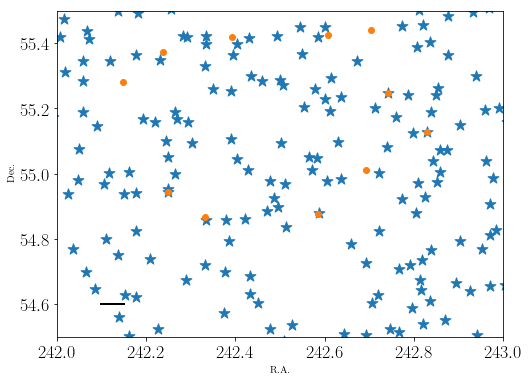

In [95]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
plt.scatter(cat_cen['RA'],cat_cen['DEC'],marker='*',s=130)
plt.scatter(cat_cluster['RA'],cat_cluster['Dec'])

plt.plot([242.1,242.1+1000/5.425/3600.],[54.6,54.6],linewidth=2,color='k')

plt.xlabel('R.A.')
plt.ylabel('Dec.')
plt.xlim([242,243])
plt.ylim([54.5,55.5])

In [96]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=cat_cluster['RA']*u.degree, dec=cat_cluster['Dec']*u.degree)  
catalog = SkyCoord(ra=cat_cen['RA']*u.degree, dec=cat_cen['DEC']*u.degree)  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  


idx = idx[d2d<100/5.425/3600.*u.deg]
print(len(idx))

35


### total mass distribution of satellites

### More conservative cut

In [97]:
def combine_deep(csfq, ssfq, masscut_low, masscut_high, z, path):
    try:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))+'.txt'
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    except IOError:
        affix = '_' + str(masscut_low) + '_' + str(csfq) + '_' + str(ssfq) + '_' + str(round(z, 1))
        cosmos_deep = np.genfromtxt(path+'countCOSMOS_deep'+affix)
        sxds_uddd = np.genfromtxt(path+'countSXDS_uddd'+affix)
        elais_deep = np.genfromtxt(path+'countELAIS_deep'+affix)
        xmmlss_deep = np.genfromtxt(path+'countXMM-LSS_deep'+affix)
        deep_deep = np.genfromtxt(path+'countDEEP_deep'+affix)
    
    n_cosmos = int(cosmos_deep[0])
    n_sxds = int(sxds_uddd[0])
    n_elais = int(elais_deep[0])
    n_xmmlss = int(xmmlss_deep[0])
    n_deep = int(deep_deep[0])
    n_combine = [n_cosmos, n_sxds, n_elais, n_xmmlss, n_deep]
    
    split_index = int(((len(cosmos_deep)-1)/2)+1)
    radial_cosmos = cosmos_deep[1:split_index]
    radial_sxds = sxds_uddd[1:split_index]
    radial_elais = elais_deep[1:split_index]
    radial_xmmlss = xmmlss_deep[1:split_index]
    radial_deep = deep_deep[1:split_index]
    radial_combine = np.vstack([radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais])

    radial = np.average(radial_combine, axis=0, weights=n_combine)
    
    radial_cosmos_err = cosmos_deep[split_index:]
    radial_sxds_err = sxds_uddd[split_index:]
    radial_elais_err = elais_deep[split_index:]
    radial_xmmlss_err = xmmlss_deep[split_index:]
    radial_deep_err = deep_deep[split_index:]
    radial_combine_err = [radial_cosmos, radial_sxds, radial_xmmlss, radial_deep, radial_elais]
    radial_err = np.sqrt(radial_cosmos_err**2*n_cosmos**2+radial_xmmlss_err**2*n_xmmlss**2+radial_elais_err**2*n_elais**2+radial_sxds_err**2*n_sxds**2+radial_deep_err**2*n_deep**2)/np.sum(n_combine)
    return (radial, radial_err, sum(n_combine))

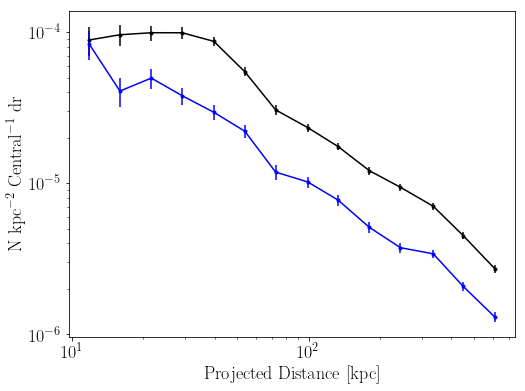

In [115]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))
path = 'CUT_deep_catalogs/total_sample/'
z=0.4

radial_95 = combine_deep('all','all', 9.5, 13.0, z, path)
radial_102 = combine_deep('all','all', 10.2, 13.0, z, path)
bin_centers = np.load(path+'bin_centers.npy')

plt.errorbar(bin_centers,radial_95[0],yerr=radial_95[1],fmt='.-k')
plt.errorbar(bin_centers,radial_102[0],yerr=radial_102[1],fmt='.-b')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.xlabel('Projected Distance [kpc]', fontsize=18)

plt.show()

1. Outer slope similar to each other
2. inner second component more significant using lower mass cut

### varying isolation criteria

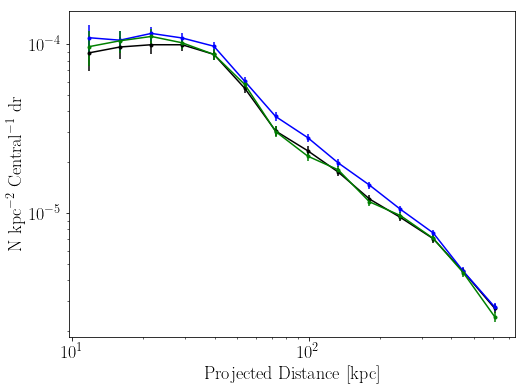

In [111]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 6))

path_1 = 'CUT_deep_catalogs/total_sample/'
path_2 = 'CUT_deep_catalogs/without_isolation/'
path_3= 'CUT_deep_catalogs/strong_isolation_criteria/'
z=0.4

radial_iso = combine_deep('all','all', 9.5, 13.0, z, path_1)
radial_noiso = combine_deep('all','all', 9.5, 13.0, z, path_2)
radial_strongiso = combine_deep('all','all', 9.5, 13.0, z, path_3)
bin_centers = np.load(path+'bin_centers.npy')

plt.errorbar(bin_centers,radial_iso[0],yerr=radial_iso[1],fmt='.-k')
plt.errorbar(bin_centers,radial_noiso[0],yerr=radial_noiso[1],fmt='.-b')
plt.errorbar(bin_centers,radial_strongiso[0],yerr=radial_strongiso[1],fmt='.-g')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=18)
plt.xlabel('Projected Distance [kpc]', fontsize=18)

plt.show()

###  influence of mass/photoz error

see difference in $r_s$ and significance of inner sersic profile